### Connecting to Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Importing Libraries

In [0]:
import os
import numpy as np
import pandas as pd
import json
from tqdm import tqdm
from bs4 import BeautifulSoup
import re
from textblob import TextBlob

ROOT_DIR="/content/drive/My Drive/"

### Downloading Dataset to Kaggle

In [3]:

!pip install -q kaggle

!mkdir -p ~/.kaggle
!cp "/content/drive/My Drive/kaggle.json" kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle competitions download -c tensorflow2-question-answering

cp: cannot stat 'kaggle.json': No such file or directory
100% 4.45G/4.46G [00:41<00:00, 101MB/s]
100% 4.46G/4.46G [00:41<00:00, 116MB/s]
  0% 0.00/4.78M [00:00<?, ?B/s]
100% 4.78M/4.78M [00:00<00:00, 158MB/s]
  0% 0.00/18.2k [00:00<?, ?B/s]
100% 18.2k/18.2k [00:00<00:00, 15.8MB/s]


In [4]:
from google.colab import drive
drive.mount('/content/drive')

#os.makedirs(ROOT_DIR+"TF_QA_DATA")
#DATA_PATH=os.path.join(ROOT_DIR,"TF_QA_DATA")

!unzip "/content/simplified-nq-train.jsonl.zip"
#!cp "/content/simplified-nq-train.jsonl" DATA_PATH

!unzip "/content/simplified-nq-test.jsonl.zip"
#!cp "/content/simplified-nq-test.jsonl" DATA_PATH




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  /content/simplified-nq-train.jsonl.zip
  inflating: simplified-nq-train.jsonl  
Archive:  /content/simplified-nq-test.jsonl.zip
  inflating: simplified-nq-test.jsonl  


### Utility Functions

In [0]:
def read_dataset(path,sample=True,chunksize=0):
  if sample==True:
    df=list()
    with open(path,'rt') as reader:
      for i in tqdm(range(0,chunksize)):
        df.append(json.loads(reader.readline()))
    df=pd.DataFrame(df)
    print ("Train Data has {} rows and {} columns.".format(df.shape[0],df.shape[1]))
    return df
  else:
    df=pd.read_json(path,orient='records',lines=True)
    print ("Test Data has {} rows and {} columns.".format(df.shape[0],df.shape[1]))
    return df

def prepare_dataset(train_df=None,chunksize=0,prepare_csv=False):
  if train_df is not None:
    example_id=list()
    document_text=list()
    question=list()
    pred_short_answer=list()
    possible_long_ans=list()
    pred_long_answer=list()
    pred_yes_no_ans=list()
    doc_url=list()

    for idx in tqdm(range(chunksize)):
      example_id.append(train_df.loc[idx,'example_id'])


      first_document=train_df.loc[idx,'document_text'].split()

      possible_answers=list()
      candidate_answers=train_df.loc[idx,'long_answer_candidates']
      for i in candidate_answers:
        if (i['top_level']==True):
          possible_answers.append(' '.join ( first_document [ i['start_token'] : i['end_token'] ] ))
      
      possible_long_ans.append(possible_answers)

      first_document=train_df.loc[idx,'document_text'].split()
      document_text.append(' '.join(train_df.loc[idx,'document_text'].split()))

      question.append(train_df.loc[idx,'question_text'])

      ann=train_df.loc[idx,'annotations']

      if (len(ann[0]['long_answer'])) > 0:
        first_long_answer=ann[0]['long_answer']
        ans=' '.join(first_document[first_long_answer['start_token']:first_long_answer['end_token']])
        
        pred_long_answer.append(ans)
      else:
        pred_long_answer.append(None)
      
      if (len(ann[0]['short_answers'])) > 0:
        first_short_answer=ann[0]['short_answers'][0]
        
        ans=' '.join(first_document[first_short_answer['start_token']:first_short_answer['end_token']])
        pred_short_answer.append(ans)
      else:
        pred_short_answer.append(None)
      
      if (ann[0]['yes_no_answer']) != 'NONE':
        pred_yes_no_ans.append(ann[0]['yes_no_answer'])
      else:
        pred_yes_no_ans.append(None)

      doc_url.append(train_df.loc[idx,'document_url'])

    
    data_df=(pd.DataFrame({'example_id':example_id,'text':document_text,'candidate_answers':possible_long_ans,'question':question,
                              'pred_short_ans':pred_short_answer,
                              'pred_long_ans':pred_long_answer,'pred_yes_no_ans':pred_yes_no_ans,
                              'doc_url':doc_url}))
    # pattern=r"<[^>]*>"
    # data_df['text']=data_df['text'].apply(lambda x:[re.sub(pattern," ",y) for y in x])
    # data_df['question']=data_df['question'].apply(lambda x : re.sub(pattern," ",x) if x!=None else None)
    # data_df['candidate_answers']=data_df['candidate_answers'].apply(lambda x : re.sub(pattern," ",x) if x!=None else None)
    # data_df['pred_short_ans']=data_df['pred_short_ans'].apply(lambda x : re.sub(pattern," ",x) if x!=None else None)
    # data_df['pred_long_ans']=data_df['pred_long_ans'].apply(lambda x : re.sub(pattern," ",x) if x!=None else None)
    
    if prepare_csv==True:
      data_df.csv('train_data',header=True,index=False)

    return data_df 

def break_sen(paras):
  blob=TextBlob(" ")
  for idx in tqdm(range(0,len(paras))):
    blob+=TextBlob(" ".join(paras[idx]))
  sentence=[idx.raw for idx in blob.sentences]
  from google.colab import drive
  drive.mount('/content/drive')
  data=pd.DataFrame({'sentence':sentence})
  data.to_csv('/content/drive/My Drive/TF_QA_DATA_SQuAD_FORMAT/sentence.csv',mode='a',header=False,index=False)
  return 'done'

In [6]:
train=read_dataset('/content/simplified-nq-train.jsonl',chunksize=500)
test=read_dataset('/content/simplified-nq-test.jsonl',sample=False,chunksize=0)
train.head()

100%|██████████| 500/500 [00:00<00:00, 2263.99it/s]


Train Data has 500 rows and 6 columns.
Test Data has 346 rows and 4 columns.


,document_text,long_answer_candidates,question_text,annotations,document_url,example_id
0,Email marketing - Wikipedia <H1> Email marketi...,"[{'start_token': 14, 'top_level': True, 'end_t...",which is the most common use of opt-in e-mail ...,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Em...,5655493461695504401
1,The Mother ( How I Met Your Mother ) - wikiped...,"[{'start_token': 28, 'top_level': True, 'end_t...",how i.met your mother who is the mother,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Th...,5328212470870865242
2,Human fertilization - wikipedia <H1> Human fer...,"[{'start_token': 14, 'top_level': True, 'end_t...",what type of fertilisation takes place in humans,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Hu...,4435104480114867852
3,List of National Football League career quarte...,"[{'start_token': 28, 'top_level': True, 'end_t...",who had the most wins in the nfl,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Li...,5289242154789678439
4,Roanoke Colony - wikipedia <H1> Roanoke Colony...,"[{'start_token': 32, 'top_level': True, 'end_t...",what happened to the lost settlement of roanoke,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Ro...,5489863933082811018


### First Glance at Data

In [0]:
index=0

In [9]:
first_question=train.loc[index,'question_text'].split()
' '.join(first_question)


'which is the most common use of opt-in e-mail marketing'

In [0]:
first_document=train.loc[index,'document_text'].split()
document=' '.join(first_document)


In [11]:
first_annotation=train.loc[index,'annotations']
first_annotation

[{'annotation_id': 593165450220027640,
  'long_answer': {'candidate_index': 54,
   'end_token': 2019,
   'start_token': 1952},
  'short_answers': [{'end_token': 1969, 'start_token': 1960}],
  'yes_no_answer': 'NONE'}]

In [12]:
first_long_answer=first_annotation[0]['long_answer']
first_long_answer

{'candidate_index': 54, 'end_token': 2019, 'start_token': 1952}

In [13]:
long_answer=' '.join(first_document[first_long_answer['start_token']:first_long_answer['end_token']])
long_answer

"<P> A common example of permission marketing is a newsletter sent to an advertising firm 's customers . Such newsletters inform customers of upcoming events or promotions , or new products . In this type of advertising , a company that wants to send a newsletter to their customers may ask them at the point of purchase if they would like to receive the newsletter . </P>"

In [14]:
first_possible_long_answers=train.loc[index,'long_answer_candidates']
first_possible_long_answers

[{'end_token': 170, 'start_token': 14, 'top_level': True},
 {'end_token': 169, 'start_token': 15, 'top_level': False},
 {'end_token': 103, 'start_token': 52, 'top_level': False},
 {'end_token': 102, 'start_token': 53, 'top_level': False},
 {'end_token': 156, 'start_token': 103, 'top_level': False},
 {'end_token': 155, 'start_token': 104, 'top_level': False},
 {'end_token': 321, 'start_token': 170, 'top_level': True},
 {'end_token': 180, 'start_token': 171, 'top_level': False},
 {'end_token': 186, 'start_token': 180, 'top_level': False},
 {'end_token': 224, 'start_token': 186, 'top_level': False},
 {'end_token': 222, 'start_token': 188, 'top_level': False},
 {'end_token': 194, 'start_token': 189, 'top_level': False},
 {'end_token': 200, 'start_token': 194, 'top_level': False},
 {'end_token': 205, 'start_token': 200, 'top_level': False},
 {'end_token': 231, 'start_token': 224, 'top_level': False},
 {'end_token': 257, 'start_token': 231, 'top_level': False},
 {'end_token': 255, 'start_tok

In [15]:
possible_answers=list()
for i , idx in enumerate( first_possible_long_answers ):
  if (idx['top_level']==True):
    print ( "Possible Long Answer {} is = {} "\
           .format( i + 1 , ' '.join ( first_document [ idx['start_token'] : idx['end_token'] ] ) ) )
    possible_answers.append(' '.join ( first_document [ idx['start_token'] : idx['end_token'] ] ))

possible_answers=' '.join([jdx for jdx in possible_answers])

Possible Long Answer 1 is = <Table> <Tr> <Td> </Td> <Td> ( hide ) This article has multiple issues . Please help improve it or discuss these issues on the talk page . ( Learn how and when to remove these template messages ) <Table> <Tr> <Td> </Td> <Td> This article needs additional citations for verification . Please help improve this article by adding citations to reliable sources . Unsourced material may be challenged and removed . ( September 2014 ) ( Learn how and when to remove this template message ) </Td> </Tr> </Table> <Table> <Tr> <Td> </Td> <Td> This article possibly contains original research . Please improve it by verifying the claims made and adding inline citations . Statements consisting only of original research should be removed . ( January 2015 ) ( Learn how and when to remove this template message ) </Td> </Tr> </Table> ( Learn how and when to remove this template message ) </Td> </Tr> </Table> 
Possible Long Answer 7 is = <Table> <Tr> <Td> Part of a series on </Td> 

In [16]:
possible_answers

"<Table> <Tr> <Td> </Td> <Td> ( hide ) This article has multiple issues . Please help improve it or discuss these issues on the talk page . ( Learn how and when to remove these template messages ) <Table> <Tr> <Td> </Td> <Td> This article needs additional citations for verification . Please help improve this article by adding citations to reliable sources . Unsourced material may be challenged and removed . ( September 2014 ) ( Learn how and when to remove this template message ) </Td> </Tr> </Table> <Table> <Tr> <Td> </Td> <Td> This article possibly contains original research . Please improve it by verifying the claims made and adding inline citations . Statements consisting only of original research should be removed . ( January 2015 ) ( Learn how and when to remove this template message ) </Td> </Tr> </Table> ( Learn how and when to remove this template message ) </Td> </Tr> </Table> <Table> <Tr> <Td> Part of a series on </Td> </Tr> <Tr> <Th> Internet marketing </Th> </Tr> <Tr> <Td>

In [17]:
first_short_answer=first_annotation[0]['short_answers'][0]
first_short_answer=' '.join(first_document[first_short_answer['start_token']:first_short_answer['end_token']])
first_short_answer

"a newsletter sent to an advertising firm 's customers"

### Perparing Dataset in format of SQuAD Dataset

In [18]:
df=prepare_dataset(train_df=train,chunksize=500,prepare_csv=False)

100%|██████████| 500/500 [00:00<00:00, 536.76it/s]


In [19]:
df

,example_id,text,candidate_answers,question,pred_short_ans,pred_long_ans,pred_yes_no_ans,doc_url
0,5655493461695504401,Email marketing - Wikipedia <H1> Email marketi...,[<Table> <Tr> <Td> </Td> <Td> ( hide ) This ar...,which is the most common use of opt-in e-mail ...,a newsletter sent to an advertising firm 's cu...,<P> A common example of permission marketing i...,None,https://en.wikipedia.org//w/index.php?title=Em...
1,5328212470870865242,The Mother ( How I Met Your Mother ) - wikiped...,"[<Table> <Tr> <Th_colspan=""2""> Tracy McConnell...",how i.met your mother who is the mother,Tracy McConnell,"<P> Tracy McConnell , better known as `` The M...",None,https://en.wikipedia.org//w/index.php?title=Th...
2,4435104480114867852,Human fertilization - wikipedia <H1> Human fer...,[<Table> <Tr> <Td> Part of a series on </Td> <...,what type of fertilisation takes place in humans,None,<P> The process of fertilization involves a sp...,None,https://en.wikipedia.org//w/index.php?title=Hu...
3,5289242154789678439,List of National Football League career quarte...,[<Table> <Tr> <Th> NFL lists </Th> </Tr> <Tr> ...,who had the most wins in the nfl,Tom Brady,<P> Active quarterback Tom Brady holds the rec...,None,https://en.wikipedia.org//w/index.php?title=Li...
4,5489863933082811018,Roanoke Colony - wikipedia <H1> Roanoke Colony...,[<Table> <Tr> <Td> </Td> <Td> This article 's ...,what happened to the lost settlement of roanoke,None,,None,https://en.wikipedia.org//w/index.php?title=Ro...
...,...,...,...,...,...,...,...,...
495,4598368318972963259,Orlando Magic - wikipedia <H1> Orlando Magic <...,"[<Table> <Tr> <Th_colspan=""2""> Orlando Magic <...",when did the orlando magic win the nba champio...,None,"<Table> <Tr> <Th_colspan=""2""> Orlando Magic </...",None,https://en.wikipedia.org//w/index.php?title=Or...
496,3757514004496901116,Cranial nerves - wikipedia <H1> Cranial nerves...,"[<Table> <Tr> <Th_colspan=""2""> Cranial nerves ...",where do the cranial nerves branch off the brain,None,"<P> The terminal nerves , olfactory nerves ( I...",None,https://en.wikipedia.org//w/index.php?title=Cr...
497,-2457931416336045741,List of African - American United States Senat...,[<P> The United States Senate has had ten Afri...,how many african-american senators are there i...,None,"<Table> <Tr> <Th_colspan=""3""> Senator </Th> <T...",None,https://en.wikipedia.org//w/index.php?title=Li...
498,5580799052133959445,Spanish Ladies - wikipedia <H1> Spanish Ladies...,[<P> `` Spanish Ladies '' ( Roud 687 ) is a tr...,what is the song quint sings in jaws,None,<P> The song notably appeared in the 1975 film...,None,https://en.wikipedia.org//w/index.php?title=Sp...


In [0]:
df.to_csv("TF_QA_DATA_SQuAD_FORMAT.csv",header=True,index=False)

In [21]:
from google.colab import drive
drive.mount('/content/drive')

DATA_PATH=os.path.join(ROOT_DIR,"TF_QA_DATA_SQuAD_FORMAT")
!cp TF_QA_DATA_SQuAD_FORMAT.csv "/content/drive/My Drive/TF_QA_DATA_SQuAD_FORMAT/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Reading SQuAD formatted Data

In [22]:
df=pd.read_csv("/content/drive/My Drive/TF_QA_DATA_SQuAD_FORMAT/TF_QA_DATA_SQuAD_FORMAT.csv")
!python -m textblob.download_corpora

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
Finished.


### Splitting Sentences

In [0]:
paras=list(df['text'].drop_duplicates().reset_index(drop=True))
paras=[idx.split() for idx in paras]

## Infersent

In [0]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
import os
os.makedirs("/content/drive/My Drive/InferSent")

Mounted at /content/drive


In [0]:
!git clone https://github.com/facebookresearch/InferSent.git "/content/drive/My Drive/InferSent/"
%cd "/content/drive/My Drive/InferSent/"
!ls

Cloning into '/content/drive/My Drive/InferSent'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 259 (delta 7), reused 13 (delta 4), pack-reused 240
Receiving objects: 100% (259/259), 448.95 KiB | 7.48 MiB/s, done.
Resolving deltas: 100% (131/131), done.
/content/drive/My Drive/InferSent
CODE_OF_CONDUCT.md  demo.ipynb		 LICENSE    README.md
CONTRIBUTING.md     extract_features.py  models.py  samples.txt


In [0]:
%cd /content/drive/My Drive/InferSent/

/content/drive/My Drive/InferSent


In [0]:
!mkdir GloVe
!curl -Lo GloVe/glove.840B.300d.zip http://nlp.stanford.edu/data/glove.840B.300d.zip
!unzip GloVe/glove.840B.300d.zip -d GloVe/
!mkdir fastText
!curl -Lo fastText/crawl-300d-2M.vec.zip https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip
!unzip fastText/crawl-300d-2M.vec.zip -d fastText/

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0   315    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0   352    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 2075M  100 2075M    0     0  2092k      0  0:16:55  0:16:55 --:--:-- 2734k
Archive:  GloVe/glove.840B.300d.zip
  inflating: GloVe/glove.840B.300d.txt  
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1453M  100 1453M    0     0  25.6M      0  0:00:56  0:00:56 --:--:-- 26.6M
Archive:  fastText/crawl-300d-2M.vec.zip
  inflating: fastText/crawl-300d-2M.vec  


In [0]:
!mkdir encoder
!curl -Lo encoder/infersent1.pkl https://dl.fbaipublicfiles.com/infersent/infersent1.pkl
!curl -Lo encoder/infersent2.pkl https://dl.fbaipublicfiles.com/infersent/infersent2.pkl


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  146M  100  146M    0     0  22.2M      0  0:00:06  0:00:06 --:--:-- 26.4M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  146M  100  146M    0     0  21.2M      0  0:00:06  0:00:06 --:--:-- 25.3M


In [0]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [0]:
import torch
import pickle
from models import InferSent
V = 2
MODEL_PATH = 'encoder/infersent%s.pkl' % V
params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                'pool_type': 'max', 'dpout_model': 0.0, 'version': V}
infersent = InferSent(params_model)
infersent.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

In [0]:
#!unzip fastText/crawl-300d-2M.vec.zip -d fastText/
W2V_PATH = '/content/drive/My Drive/InferSent/fastText/crawl-300d-2M.vec'
infersent.set_w2v_path(W2V_PATH)

In [0]:
infersent.build_vocab(fg, tokenize=True)

Found 8018(/8197) words with w2v vectors
Vocab size : 8018


In [0]:
dict_embeddings = {}
for i in tqdm(range(len(fg))): 
    dict_embeddings[fg[i]] = infersent.encode([fg[i]], tokenize=True)

100%|██████████| 1337/1337 [06:06<00:00,  1.28s/it]


In [0]:
d1 = {key:dict_embeddings[key] for i, key in enumerate(dict_embeddings) if i % 2 == 0}
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
with open('/content/drive/My Drive/TF_QA_DATA_SQuAD_FORMAT/text_embeddings1.pickle', 'wb') as handle:
    pickle.dump(d1, handle)

Mounted at /content/drive


In [0]:
questions = list(df["question"])
len(questions)


20

In [0]:
for i in range(len(questions)):
    dict_embeddings[questions[i]] = infersent.encode([questions[i]], tokenize=True)

In [0]:
d2 = {key:dict_embeddings[key] for i, key in enumerate(dict_embeddings) if i % 2 == 1}
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
with open('/content/drive/My Drive/TF_QA_DATA_SQuAD_FORMAT/question_embeddings1.pickle', 'wb') as handle:
    pickle.dump(d2, handle)

Mounted at /content/drive


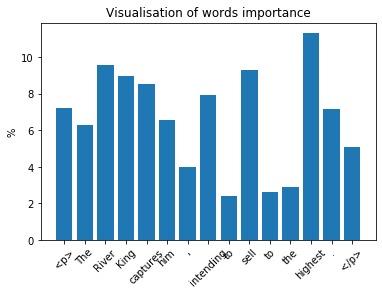

(tensor([[ 0.0075,  0.0429,  0.1156,  ...,  0.0331, -0.0059,  0.0241]],
        grad_fn=<MaxBackward0>), array([[ 0,  5,  3, ...,  9,  9, 12]]))

In [0]:
infersent.visualize('The River King captures him , intending to sell Sunny to the highest bidder .', tokenize=True)

In [0]:
d1

{" Nashville sound Stylistic origins Country music , pop music Cultural origins 1950s Nashville , Tennessee Typical instruments Guitar , strings , bass , drum , banjo , vocals Derivative forms Countrypolitan , country pop Other topics Country musicians -- List of years in country music The Nashville sound originated during the mid 1950s as a subgenre of American country music , replacing the chart dominance of the rough honky tonk music which was most popular in the 1940s and 1950s with `` smooth strings and choruses '' , `` sophisticated background vocals '' and `` smooth tempos '' .": array([[0.00746889, 0.03688128, 0.17947266, ..., 0.04323539, 0.05870793,
         0.02062749]], dtype=float32),
 ' This article needs additional citations for verification .': array([[ 0.00746889, -0.05329636,  0.02447322, ..., -0.02403872,
          0.00022337,  0.00818   ]], dtype=float32),
 "'' ) In another scene , he is drafted into the army under the command of the fearsome ( and , ultimately , cow

## **Text Preprocessing**

In [0]:
sen="The so - called `` Zuniga Map '' ( named for Pedro de Zúñiga , the Spanish ambassador to England , who had secured a copy and passed it on to Philip III of Spain ) , drawn about 1607 by the Jamestown settler Francis Nelson , also gives credence to this claim ."

In [0]:
sentences=list()
for i in tqdm(range(len(fg))):
  sentences.append(fg[i][0])

100%|██████████| 1733/1733 [00:00<00:00, 469313.59it/s]


In [0]:
len(sentences)

1733

In [0]:
def preprocess_text(text):
  text=text.strip()
  text=re.sub(r"[^a-zA-Z0-9(),.]+", " ", text)
  text=text.split()
  text=' '.join(text)
  return text

In [0]:
for i in tqdm(range(len(sentences))):
  sentences[i]=preprocess_text(sentences[i])

100%|██████████| 1733/1733 [00:00<00:00, 77023.72it/s]


In [0]:
import numpy as np

In [0]:
def give_len(sentences,length=0):
  count=0
  for i in tqdm(range(len(sentences))):
    if len(sentences[i])==length:
      count=count+1
  return count

In [0]:
sentences

['Please help improve it or discuss these issues on the talk page .',
 '( Learn how and when to remove these template messages ) This article needs additional citations for verification .',
 'Please help improve this article by adding citations to reliable sources .',
 'Unsourced material may be challenged and removed .',
 '( September 2014 ) ( Learn how and when to remove this template message ) This article possibly contains original research .',
 'Please improve it by verifying the claims made and adding inline citations .',
 'Statements consisting only of original research should be removed .',
 '( January 2015 ) ( Learn how and when to remove this template message ) ( Learn how and when to remove this template message ) Part of a series on Internet marketing Search engine optimization Local search engine optimisation Social media marketing Email marketing Referral marketing Content marketing Native advertising Search engine marketing Pay per click Cost per impression Search analyt